In [3]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import scipy
import scipy.stats
from tqdm import tqdm
import time
%pylab inline

plt.rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Решение в матричной форме

In [ ]:
class OrdinaryLeastSquares:
    def __init__(self):
        pass
    
    def fit(self, X, y):
        """Находим веса линейной регрессии аналитическим методом"""
        self.weights = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
        
    def predict(self, X):
        """с помощью найденных весов делаем предсказание"""
        return np.dot(X, self.weights)

Веса функции:  [[ 3.06813535]
 [ 2.13761829]
 [-0.23970454]]


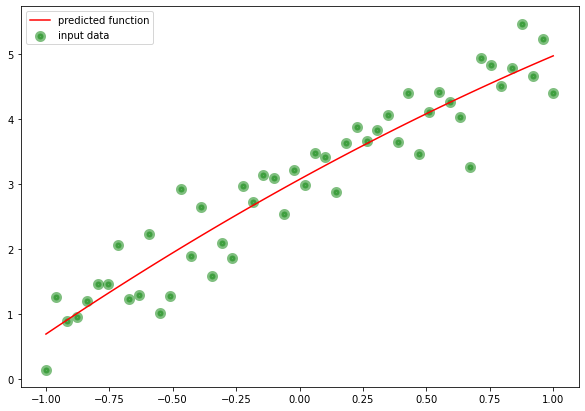

In [ ]:
#определяем нашу независимую переменную
X = np.linspace(-1,1,50)
#и зависимую переменную
y_array = np.array([2 * (x + np.random.normal(0,0.25)) + 3 for x in X]).reshape(-1,1)
#формуруем матрицу признаков(design matrix) для обучения - не забываем добавить вектор 1, коэфициент при котором будет соответсвовать смещению
x_array = np.array([X**0, X**1, X**2]).T

#обучение модели
ols = OrdinaryLeastSquares()
ols.fit(x_array, y_array)

predictions = ols.predict(x_array)
print('Веса функции: ', ols.weights)

#визуализация предсказания и исходных данных
plt.scatter(X, y_array, label='input data', c = 'g',linewidths=5, alpha=0.5)
plt.plot(X, predictions, color='r',label='predicted function')
plt.legend()

### Решение итеративным способом аппроксимации квадратичной функции линейной регрессией

y_array:  (50, 1)
Weights:  [[ 5.00461138]
 [-0.03469645]
 [ 1.0372094 ]]
Number of iters:  9706


Text(0.5, 1.0, 'График ошибки')

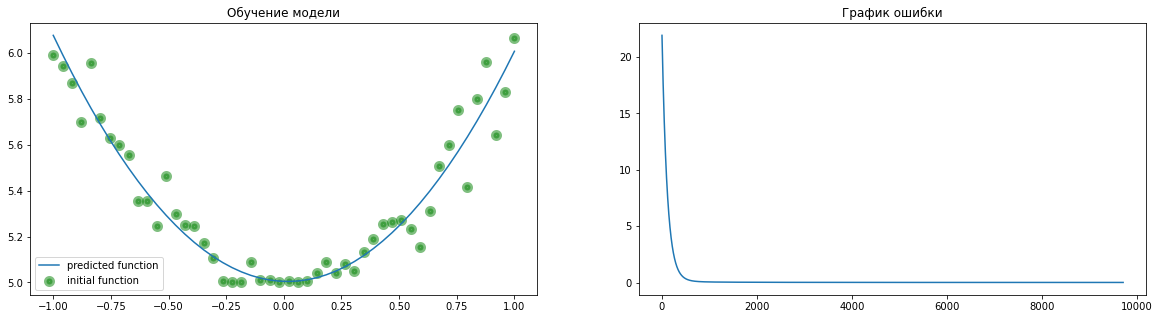

In [ ]:
class IterativeLinearRegression:
    def __init__(self, learning_rate, iters):
        # количетсво итераций
        self.iters = iters
        # шаг для обновления градиента
        self.learning_rate = learning_rate
        self.tol = 1e-5
        
    def fit_with_while(self, X, y):
        """обучение линейной регресии численным методом с помощью линейной регрессии до сходимости"""
        loss_list = []
        weights_list = []
        
        # задаем наш вектор параметров - вектором случайных чисел
        self.weights = np.random.rand(X.shape[1], 1)
        weights_list.append(self.weights)
        
        # делаем первую итерацию обновления весов 
        loss_grad = self.loss_grad(X, y)
        step = self.learning_rate * loss_grad / len(X)
        self.weights = self.weights - step
        weights_list.append(self.weights)
        
        i = 1
        # обучаем нашу модель, пока разница нормы весов на текущем и предыдущем этапах не меньше self.tol
        while np.linalg.norm(weights_list[i] - weights_list[i - 1]) > self.tol:
            #обновление весов
            loss_grad = self.loss_grad(X, y)
            step = self.learning_rate * loss_grad / len(X)
            self.weights = self.weights - step
            #рассчет ошибки
            loss = self.loss(X, y)
            # ошибку сохраняем - это нам поможет потом визуализировать процесс обучения
            loss_list.append(loss)
            
            weights_list.append(self.weights)
            i += 1
        return loss_list
    
    def fit(self, X, y):
        """обучение линейной регресии численным методом с помощью линейной регрессии на через указание количества итераций """
        loss_list = []
        weights_list = []
        self.weights = np.random.rand(X.shape[1], 1)
        for _ in range(self.iters):
            #step calculation
            loss_grad = self.loss_grad(X, y)
            step = self.learning_rate * loss_grad / len(X)
            self.weights = self.weights - step
            #evaluation
            loss = self.loss(X, y)
            
            loss_list.append(loss)
        return loss_list
        
    def predict(self, X):
        return np.dot(X, self.weights)
    
    def loss(self, X, y):
        """средне-квадратичная ошибка"""
        y_hat = np.dot(X, self.weights)
        loss = 1/len(X) * np.sum((y_hat - y)**2)
        return loss
    
    def loss_grad(self, X,y):
        """градиент средне-квадратичной ошибки"""
        y_hat = np.dot(X, self.weights)
        loss_gradient = 2/len(X) * np.dot(X.T, (y_hat - y))
        return loss_gradient
    

X = np.linspace(-1,1,50)

y_array = np.array([(x + np.random.normal(0,0.08))**2 + 5 for x in X]).reshape(-1,1)

print('y_array: ', y_array.shape)

x_array = np.array([X**0, X**1, X**2]).T

ilr = IterativeLinearRegression(learning_rate=0.1, iters=1000)
train_history = ilr.fit_with_while(x_array, y_array)
print('Weights: ', ilr.weights)
print('Number of iters: ', len(train_history))

predictions = ilr.predict(x_array)

# визуализация предсказания и процесса обучения
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

ax1.scatter(X, y_array, label='initial function', c = 'g',linewidths=5, alpha=0.5)
ax1.plot(X, predictions, label='predicted function')

ax1.set_title('Обучение модели')
ax1.legend()

ax2.plot(np.arange(len(train_history)), train_history)
ax2.set_title('График ошибки')

### Работа с датасетом

In [ ]:
# чтение данных с поомощью pandas
df = pd.read_csv('bike.csv')
# определение признаков для работы
feature_names = ['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']
# нормализация признаков
scaled_df = df[feature_names].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
scaled_df['count'] = df['count'].tolist()
scaled_df.head()

,holiday,humidity,summer,temp,windspeed,workingday,count
0,-0.156786,0.987606,-0.914784,-0.925973,0.926255,0.68378,2
1,-0.156786,-0.307982,1.092789,-0.043565,0.353309,0.68378,157
2,-0.156786,-0.979769,1.092789,2.309524,0.124745,0.68378,233
3,-0.156786,1.323500,1.092789,0.446662,0.582641,0.68378,98
4,-0.156786,0.651713,-0.914784,-1.416200,-0.905330,0.68378,6


### Оценка признаков

In [ ]:
from scipy.stats import ncf, f


def calculate_significance(y_true, y_preds, coefs_num):
    """
    функция рассчета статистик и коэфициента детерминации
    """
    #don't forget bias
    coefs_num += 1
    
    ss_reg = ((y_true - y_preds) ** 2).sum(axis=0)
    ss_mean = ((y_true - np.average(y_true, axis=0)) ** 2).sum(axis=0)
    r_squared = (ss_mean - ss_reg) / ss_mean
    adj_r_squared = 1 - (len(y_true) - 1)/(len(y_true)- coefs_num - 1)*(1-r_squared)
    
    df1 = (coefs_num - 1)
    df2 = (len(y_true) - coefs_num)

    numerator = r_squared/df1
    denumerator = (1 - r_squared)/df2
    F = numerator / denumerator

    #area to the right in pdf
    p_value = 1 - f.cdf(F, df1, df2)

    return {'p-value': p_value, 'F stat': F, 'r_squared': r_squared, 'adj_r_squared': adj_r_squared}

In [ ]:
# формирование данных для обучения
bias_term = np.ones((len(scaled_df), 1))#добавляем признак из 1 - вектор смещения
x_array = np.concatenate([bias_term, np.array(scaled_df[feature_names])], axis=1)
y_array = np.array(scaled_df['count']).reshape(-1,1)

Number of iters:  129819


{'p-value': array([1.11022302e-16]),
 'F stat': array([270.26752883]),
 'r_squared': array([0.35140713]),
 'adj_r_squared': array([0.3498897])}

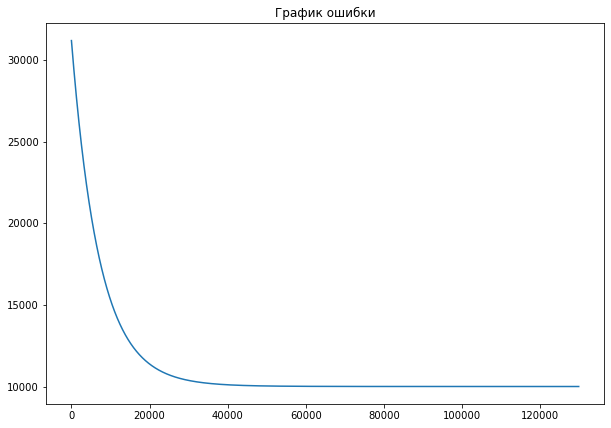

In [ ]:
ilr = IterativeLinearRegression(learning_rate=0.1, iters=100000)
train_history = ilr.fit_with_while(x_array, y_array)
predictions = ilr.predict(x_array)

print('Number of iters: ', len(train_history))

#визуализация процесса обучения
plt.plot(np.arange(len(train_history)), train_history)
plt.title('График ошибки')


calculate_significance(y_array, predictions, x_array.shape[1] - 1)

In [ ]:
#подобранные веса
print('ILR weights: ', ilr.weights)

ILR weights:  [[125.59112259]
 [  3.19528748]
 [-28.81658489]
 [ 11.49897886]
 [ 61.19566028]
 [  2.93494769]
 [ -0.23561509]]


In [ ]:
ols = OrdinaryLeastSquares()
ols.fit(x_array, y_array)
ols_predictions = ols.predict(x_array)

calculate_significance(y_array, ols_predictions, x_array.shape[1] - 1)

{'p-value': array([1.11022302e-16]),
 'F stat': array([270.27116414]),
 'r_squared': array([0.3514102]),
 'adj_r_squared': array([0.34989278])}

In [ ]:
print('OLS weights: ', ols.weights)

OLS weights:  [[125.613     ]
 [  3.18559433]
 [-28.70572394]
 [ 11.28355533]
 [ 61.39632906]
 [  2.96481203]
 [ -0.21574707]]


### Исследование мультиколлинеарности

In [ ]:
import random

def feature_generator(curr_df, feature_list):
    """
    Генерируем случайный линейно зависимый признак из нашего датафрейма
    """
    random_coll = random.sample(feature_list, 2)
    new_feature = random.choice([
        curr_df[random_coll[0]] + curr_df[random_coll[1]],
        2 * curr_df[random_coll[0]],
        curr_df[random_coll[0]] - curr_df[random_coll[1]],
        2 * curr_df[random_coll[0]] + curr_df[random_coll[1]]
    ])
    return new_feature

Суть эксперимента - проверить OLS модель при обучении с линейно-зависимыми признаками. 
Для этого на протяжении 10 экспериментов генерируем с помощью функции **feature_generator** линейно зависимый признак от исходных признаков и добавляем ее в наш датафрейм. Далее обучаем модель и смотрим на норму весов и ошибку модели. Мы ожидаем увидеть сильную флуктуацию в весах модели и в ошибке на тестовой выборке. Это покажет нам неустойчивость OLS модели к мультиколлинеарности.

In [ ]:
from numpy import linalg
from tqdm import tqdm
from copy import deepcopy

original_features = ['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']
train_features = ['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']

scaled_df_copy = deepcopy(scaled_df)

total_experiements = 10

weights_norm_list = []
error_list = []
r_squared_list = []
iters_amount_list = []


for i in tqdm(range(total_experiements)):
    if i >= 1:
        feature_name = f'new_feature_{i}'
        scaled_df_copy[feature_name] = feature_generator(scaled_df_copy, original_features)
        train_features.append(feature_name)
    print(train_features)

    # делим нашу выборку на обучающую и тестовую
    X_train, X_test, y_train, y_test = train_test_split(scaled_df_copy[train_features], scaled_df_copy['count'], random_state=42)

    # подготавливаем обучающую выборку
    bias_term = np.ones((len(X_train), 1))
    x_train = np.concatenate([bias_term, X_train], axis=1)
    y_train = np.array(y_train).reshape(-1,1)
    
    # подготавливаем тествую выборку
    bias_term = np.ones((len(X_test), 1))
    x_test = np.concatenate([bias_term, X_test], axis=1)
    y_test = np.array(y_test).reshape(-1,1)

    # ilr = IterativeLinearRegression(learning_rate=0.1, iters=100000)
    # train_history = ilr.fit_with_while(x_train, y_train)
    # predictions = ilr.predict(x_test)
    
    # обучаем аналитическим методом линейную регрессию
    ols = OrdinaryLeastSquares()
    ols.fit(x_train, y_train)
    predictions = ols.predict(x_test)

    # рассчитываем среднее весов
    weights_sum = np.mean(np.abs(ols.weights))
    # рассчитываем ошибку модели на тестовой выборке
    mse_error = 1/len(x_test) * np.sum((predictions - y_test)**2)
    print(calculate_significance(y_test, predictions, x_test.shape[1] - 1))
    r_squared = calculate_significance(y_test, predictions, x_test.shape[1] - 1)['adj_r_squared']

    r_squared_list.append(r_squared)
    weights_norm_list.append(weights_sum)
    error_list.append(mse_error)
    iters_amount_list.append(len(train_history))
    
    print()

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 218.00it/s]

['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday']
{'p-value': array([1.11022302e-16]), 'F stat': array([61.12710197]), 'r_squared': array([0.33048745]), 'adj_r_squared': array([0.32417129])}

['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday', 'new_feature_1']
{'p-value': array([1.11022302e-16]), 'F stat': array([46.17861721]), 'r_squared': array([0.3034501]), 'adj_r_squared': array([0.29593])}

['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday', 'new_feature_1', 'new_feature_2']
{'p-value': array([1.]), 'F stat': array([-72.76590782]), 'r_squared': array([-3.66411048]), 'adj_r_squared': array([-3.72083615])}

['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday', 'new_feature_1', 'new_feature_2', 'new_feature_3']
{'p-value': array([1.]), 'F stat': array([-48.2697981]), 'r_squared': array([-1.4216893]), 'adj_r_squared': array([-1.45445912])}

['holiday', 'humidity', 'summer', 'temp', 'windspeed', 'workingday', 'new_feat

Мы видим, что ошибка и веса действительно начинают флуктуировать. А коэфициент детерминации явно показывает сильное переобучение модели.

Text(0.5, 1.0, '$R^2$')

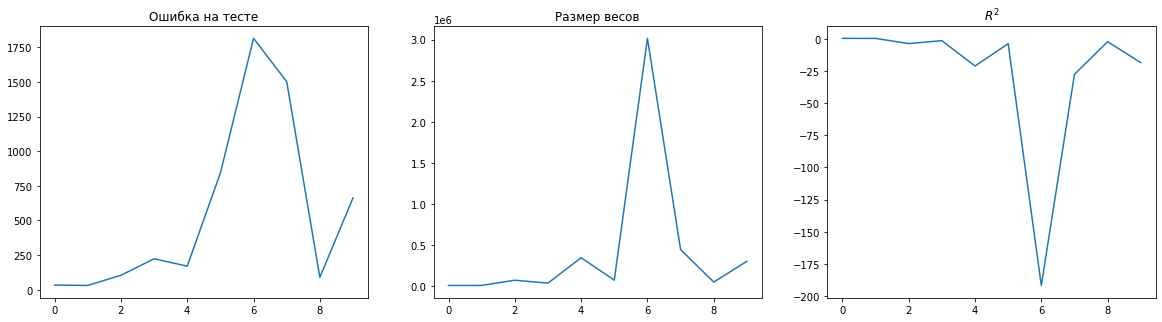

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

ax1.plot(list(range(total_experiements)), weights_norm_list)
ax1.set_title('Ошибка на тесте')

ax2.plot(list(range(total_experiements)), error_list)
ax2.set_title('Размер весов')

ax3.plot(list(range(total_experiements)), r_squared_list)
ax3.set_title('$R^2$')

### Интерпретируемое машинное обучение

На практике, линейную регрессию сам никто не пишет - используют готовые библиотеки. Так как ключевое свойство линейных моделей - интерпретируемость и возможность оценивать наш уровень доверия к таким моделям, нам необходимо множество статистик и метрик, которые позволят нам достаточно точно оценить качесвто нашей модели. Ключевой библиотекой с реализованными линейными моделями является **statmodels**.

In [ ]:
#формирование данных для модели
x_array = scaled_df[feature_names]
#добавление вектора смещения
x_array = sm.add_constant(x_array)
y_array = scaled_df['count']

#обучение модели, hasconst - то что мы добавили вектор смещения в модель
ols_model = sm.OLS(y_array, x_array, hasconst=True)
results = ols_model.fit()

#описание интерпретации таблички 
#https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/
results.summary()

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     270.3
Date:                Wed, 28 Sep 2022   Prob (F-statistic):          5.70e-277
Time:                        21:42:21   Log-Likelihood:                -18074.
No. Observations:                3000   AIC:                         3.616e+04
Df Residuals:                    2993   BIC:                         3.620e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.6130      1.829     68.680      0.000     122.027     129.199
holiday        3.1856      1.883      1.692      0.091      -0.506       6.878
humidity     -28.7057      1.989    -14.430      0.000     -32.606     -24.805
summer        11.2836      2.128      5.302      0.000       7.111      15.456
temp          61.3963      2.082     29.493      0.000      57.315      65.478
windspeed      2.9648      1.910      1.552      0.121      -0.780       6.709
workingday    -0.2157      1.890     -0.114      0.909      -3.922       3.490
==============================================================================
Omnibus:                      378.392   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              592.267
Skew:                           0.886   Prob(JB):                    2.46e-129
Kurtosis:                       4.264   Cond. No.                         1.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Практикум

In [1]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv

--2022-10-04 22:10:48--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.006s  

2022-10-04 22:10:48 (72.5 MB/s) - ‘house_prices_train.csv’ saved [460676/460676]

--2022-10-04 22:10:48--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP 

In [4]:
train_df = pd.read_csv('house_prices_train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


В данных есть пропуски - заполним их средним значением признака.

In [5]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean())
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mean())
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].mean())

Отберем действительные признаки для работы

In [6]:
num_features = ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 
                'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
                '1stFlrSF','2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 
                'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 
                'GarageCars', 'GarageArea', 'WoodDeckSF','OpenPorchSF', 
                'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
                'MiscVal', 'MoSold', 'YrSold']

### Воспользоваться методом OLS библиотеки statsmodels для рассчета коэфициентов линейной регрессии

In [9]:
### CODE HERE
from scipy import stats
import statsmodels.api as sm
X = train_df[num_features]
X = stats.zscore(X)
X = sm.add_constant(X)
y = train_df["SalePrice"]
ols_model = sm.OLS(y, X, hasconst=True)
results = ols_model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     197.2
Date:                Tue, 04 Oct 2022   Prob (F-statistic):               0.00
Time:                        22:17:21   Log-Likelihood:                -17329.
No. Observations:                1460   AIC:                         3.472e+04
Df Residuals:                    1428   BIC:                         3.489e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.809e+05    914.570    197.821

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Выберите переменные, которые статистически положительно связаны с ценой на дом. 

In [10]:
### CODE HERE
results.params[(results.params > 0) & (results.pvalues < 0.05)]

const           180921.195890
LotArea           4426.105066
OverallQual      24692.335309
OverallCond       5296.849507
YearBuilt         9043.119818
MasVnrArea        6321.241800
1stFlrSF         11603.414849
2ndFlrSF          8705.569016
GrLivArea        15749.623471
BsmtFullBath      7741.404542
TotRmsAbvGrd      7484.042721
Fireplaces        2490.102687
GarageCars        7563.807772
WoodDeckSF        3024.201010
ScreenPorch       3164.629289
dtype: float64

### Оцените модель на тестовом сете - метрики $R^2$ и RMSE. Что мы можем сказать по ошибке?

Незабудьте аналогично обработать тестовый датасет

In [18]:
### CODE HERE
from sklearn.metrics import r2_score, mean_squared_error
y_pred = results.predict()
R2 = r2_score(y_pred, y)
print("R2 = {}".format(R2))
RMSE = np.sqrt(mean_squared_error(y_pred, y))
print("RMSE = {}".format(RMSE))

R2 = 0.7663631426974713
RMSE = 34560.58986559042


### Придумайте какой-нибудь хороший новый признак. Смогли ли вы снизить ошибку на обучении за счет него?

In [ ]:
### CODE HERE

### В нашей модели много признаков. Возможно ли нам уменьшить количеcтво признаков, при этом сохранив качесвто модели?

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
MSSubClass,1.000000,0.357056,0.139781,0.032628,0.059316,0.027850,0.040581,0.022895,0.251758,0.307886,...,0.098672,0.012579,0.006100,0.012037,0.043825,0.026030,0.008283,0.007683,0.013585,0.021407
LotFrontage,0.357056,1.000000,0.306795,0.234196,0.052820,0.117598,0.082746,0.179283,0.414266,0.072483,...,0.323663,0.077106,0.137454,0.009790,0.062335,0.037684,0.180868,0.001168,0.010158,0.006768
LotArea,0.139781,0.306795,1.000000,0.105806,0.005636,0.014228,0.013788,0.103960,0.299475,0.050986,...,0.180403,0.171698,0.084774,0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,0.014261
OverallQual,0.032628,0.234196,0.105806,1.000000,0.091932,0.572323,0.550684,0.410238,0.476224,0.295493,...,0.562022,0.238923,0.308819,0.113937,0.030371,0.064886,0.065166,0.031406,0.070815,0.027347
OverallCond,0.059316,0.052820,0.005636,0.091932,1.000000,0.375983,0.073741,0.127788,0.144203,0.028942,...,0.151521,0.003334,0.032589,0.070356,0.025504,0.054811,0.001985,0.068777,0.003511,0.043950
YearBuilt,0.027850,0.117598,0.014228,0.572323,0.375983,1.000000,0.592855,0.314745,0.281986,0.010308,...,0.478954,0.224880,0.188686,0.387268,0.031355,0.050364,0.004950,0.034383,0.012398,0.013618
YearRemodAdd,0.040581,0.082746,0.013788,0.550684,0.073741,0.592855,1.000000,0.179186,0.240379,0.140024,...,0.371600,0.205726,0.226298,0.193919,0.045286,0.038740,0.005829,0.010286,0.021490,0.035743
MasVnrArea,0.022895,0.179283,0.103960,0.410238,0.127788,0.314745,0.179186,1.000000,0.342160,0.174019,...,0.372567,0.159349,0.124965,0.109849,0.018795,0.061453,0.011723,0.029815,0.005940,0.008184
1stFlrSF,0.251758,0.414266,0.299475,0.476224,0.144203,0.281986,0.240379,0.342160,1.000000,0.202646,...,0.489782,0.235459,0.211671,0.065292,0.056104,0.088758,0.131525,0.021096,0.031372,0.013604
2ndFlrSF,0.307886,0.072483,0.050986,0.295493,0.028942,0.010308,0.140024,0.174019,0.202646,1.000000,...,0.138347,0.092165,0.208026,0.061989,0.024358,0.040606,0.081487,0.016197,0.035164,0.028700


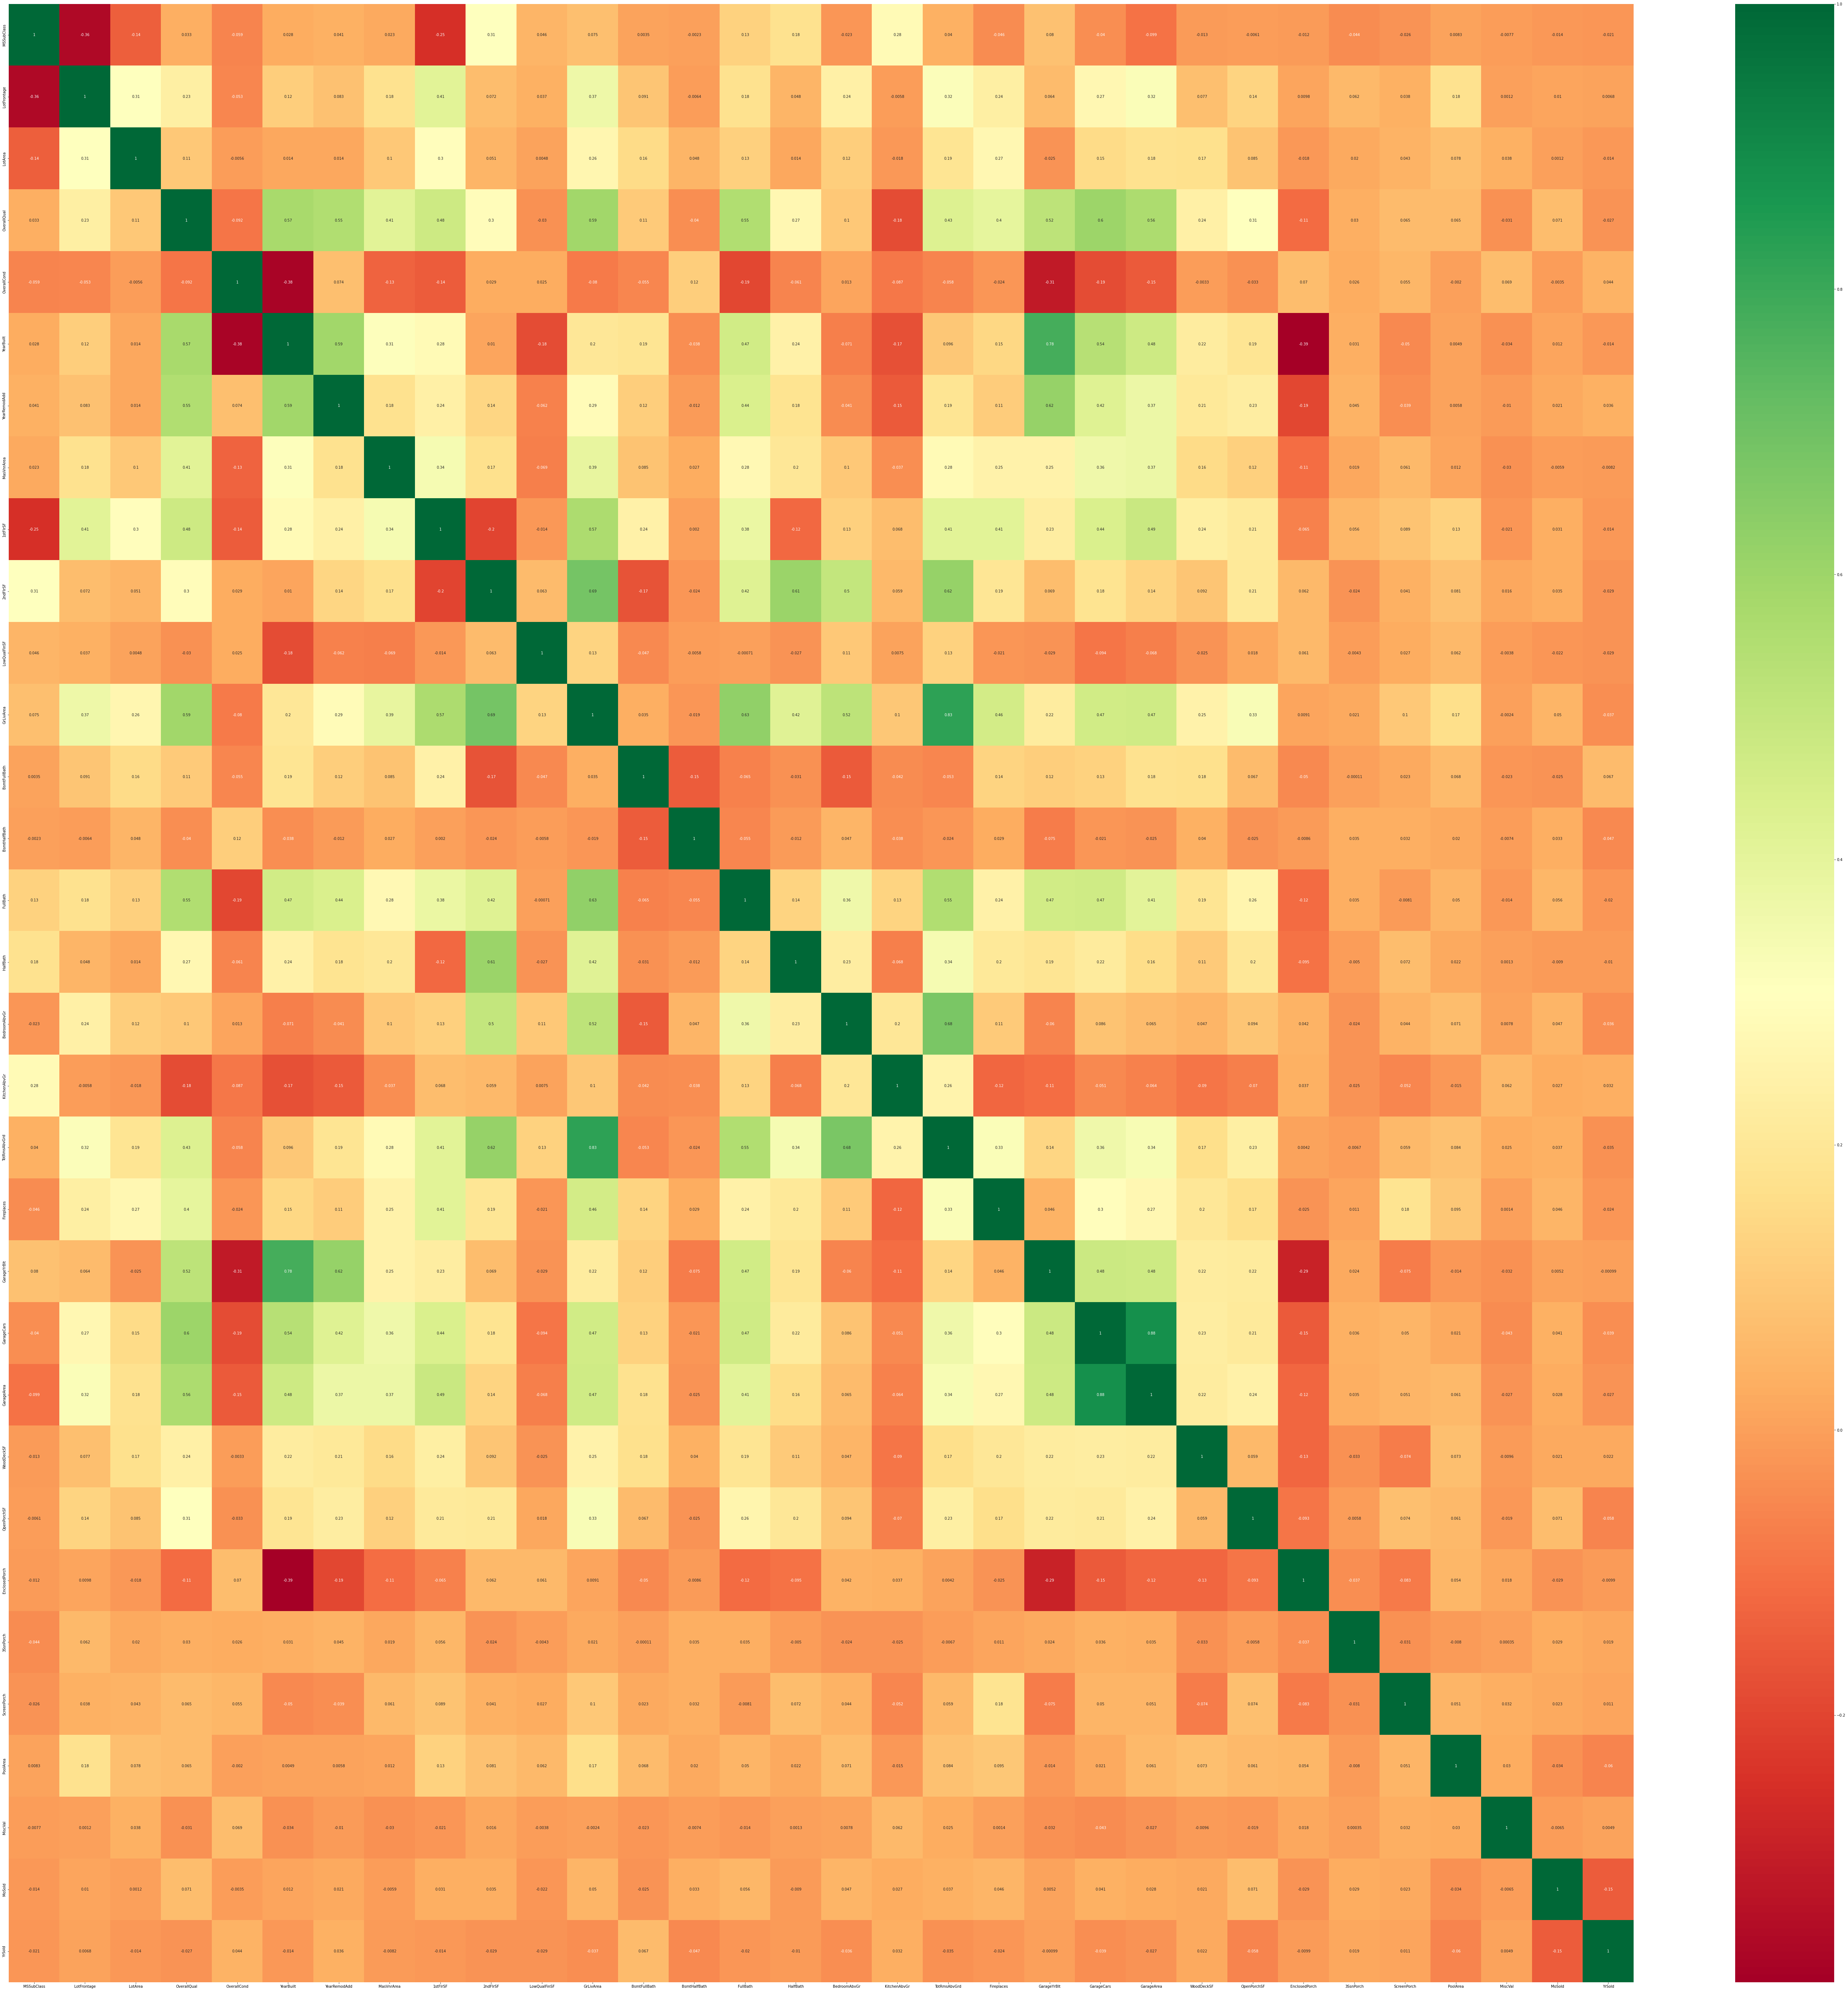

In [23]:
### CODE HERE
import seaborn as sns
from matplotlib import pyplot as plt

def compute_correlation(data):
  # get correlations of each features in dataset
  corrmat = data.corr().abs()
  top_corr_features = corrmat.index
  plt.figure(figsize=(100, 100))
  # plot heat map
  g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")
  return corrmat

del X["const"]
corrmatrix = compute_correlation(X)
corrmatrix

In [28]:
def reducing_dimension(cor_matrix, th=0.7):
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > th)]
  return to_drop

feature_to_drop = reducing_dimension(corrmatrix)
X_result = X.drop(columns=feature_to_drop)
print("feature_to_drop = {}".format(feature_to_drop))
X_result.columns

feature_to_drop = ['TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces', 'GarageCars',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')